# Using a WebScraper in Reddit for language lessons

## Introduction

When it comes to inspiring students to learn another language, teachers try to be creative but it can be hard to research and then build lessons using limited resources. 

Not only by using relevant topics to what students want to learn but also but staying on top of word use is a difficult task for teachers who are busy designing homework, lessons and other aspects of their job. With online learning, it has become increasingly hard to maintain motivation and find inspiring topics while getting students engaged. 

How can we get students to want to learn a language and how can we provide lesson materials to teachers to support them? 

### Solution 

Reddit is a popular website on a global scale, offering a majority of users, many of whom are under 30 years old an oppurtunity ask about different cultures. The vast sharing network allows conversation and language to flourish naturally. It is a great way to keep up with and find relevent topics and language use to use in lessons. 

Teachers don't have a lot on their plate, they have time to browse submissions to find trends in language and topics though right? 

Of course not! 

That is why we are building a Reddit Web Scraper that will browse reddit's `Ask an American` and `Ask Europe` subreddit submissions to find trends in langauge use and topics. We can quickly scan over 2,000 submissions to find patterns in conversations and build a report of suggestions for teachers lessons. 

### Goals
The report aims to includes: 
- recomendations on topics
- top used words for lessons 
- unique words to a subreddit
- exploration of communication styles in target languages

Teachers may use the report to build lessons, prepare for study abroad trips, or help students understand communication differences across cultures. 


### Subreddits Selected 
AskEurope was selected due to the comparable popularity to AskAnAmerican, as well as its inclusion of countries whose langauges are among the most popular taught in American high school. AskAnAmerican was included for ESL or TEFL teachers. 

In [999]:
pip install contextualSpellCheck

Note: you may need to restart the kernel to use updated packages.


In [1000]:
!pip install contractions

In [1001]:
!pip install spacy

In [1002]:
!pip install spacytextblob

In [1003]:
pip install pycountry

Note: you may need to restart the kernel to use updated packages.


In [1004]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

import contractions
import re
from nltk.stem import WordNetLemmatizer
import nltk
from collections import Counter  

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification

import datetime as dt
import contextualSpellCheck

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
import datetime as dt

import pycountry

import warnings
warnings.filterwarnings('ignore')

from sklearn.base import TransformerMixin

from sklearn.metrics import confusion_matrix

In [1005]:
len(list(pycountry.countries))

249

In [1006]:
# making a list to add to stop words

countries = []
for country in pycountry.countries:
    countries.append(country.name.lower())
    
for language in pycountry.languages:
    countries.append(language.name.lower())

In [1007]:
#load spacy 
nlp = spacy.load("en_core_web_sm") 

In [1008]:
# load spacy text blob
nlp.add_pipe('spacytextblob')

In [1009]:
# make a list of stop words to stop filtering

my_stop_words = text.ENGLISH_STOP_WORDS.union(['american', 'country', 'america', 'europe', 'european', 'usa', 'us', 'uk']) 
my_stop_words = my_stop_words.union(countries)

my_stop_words

frozenset({'dilling',
           'ninzo',
           'galo',
           'so (democratic republic of congo)',
           'iloko',
           'yucatec maya sign language',
           'i',
           'northern subanen',
           'there',
           'upper grand valley dani',
           'western bolivian guaraní',
           'vao',
           'elsewhere',
           'mono (solomon islands)',
           'seko padang',
           'kagate',
           'duvle',
           'tokharian a',
           'laura',
           'wayanad chetti',
           'tigon mbembe',
           'cree',
           'yucuna',
           'baoulé',
           "ngbaka ma'bo",
           'bouvet island',
           'terebu',
           'toromono',
           'media lengua',
           'turoyo',
           'tobo',
           'aimaq',
           'inuktitut',
           'mende (papua new guinea)',
           'biritai',
           'south muyu',
           'kunza',
           'aguna',
           'bassari',
           'são pau

In [1010]:
# read in dataframe
df = pd.read_csv('./previous.csv')

In [1011]:
df.head()

,id,title,num_comments,body,num_upvotes,time_posted,time_now,time_delta,subreddit,top_comment,text_length
0,nb0592,how common is it to not have your country's mo...,3,"/r/titlegoretaken spain as a whole, the most w...",3,2021-05-12 21:37:16,2021-05-13 01:20:57.717158,0 days 03:43:41.717163,1,"[""About 40% of the population speaks French. I...",318
1,nb3wei,most popular fast food restaurant/take-away?,14,hey guys i’m not from usa but i have seen many...,3,2021-05-13 00:31:12,2021-05-13 01:20:57.864588,0 days 00:49:45.864594,0,"[""McDonalds, Subway and Starbucks are probably...",22
2,nb339e,is it true that you guys don't like/go to mcdo...,55,here in my country they're one of the most pop...,3,2021-05-12 23:52:33,2021-05-13 01:20:58.146242,0 days 01:28:25.146249,0,['It’s not my first choice by far. I’d rather ...,49
3,nb2x64,why were football fans so upset by the europea...,3,it seemed to me like it would increase the lev...,0,2021-05-12 23:44:35,2021-05-13 01:20:58.274452,0 days 01:36:23.274458,1,"['Cause fans don\'t want ""top-notch matches"" i...",25
4,nb0xx6,why do people stick four fingers out?,29,usually it's people in a lifted truck who do i...,1,2021-05-12 22:13:39,2021-05-13 01:20:58.525647,0 days 03:07:19.525654,0,['Are you talking about waving? Do we serious...,17


In [1012]:
df.shape

(2683, 11)

In [1013]:
df.subreddit.value_counts()

0    1367
1    1316
Name: subreddit, dtype: int64

In [1014]:
df.isna().sum()

id               0
title            0
num_comments     0
body            10
num_upvotes      0
time_posted      0
time_now         0
time_delta       0
subreddit        0
top_comment      0
text_length      0
dtype: int64

In [1015]:
# get rid of null body rows

df = df[df['body'].notna()]

In [1016]:
df.shape

(2673, 11)

In [1017]:
# check if anything is duplicated 

df[df.duplicated()]

,id,title,num_comments,body,num_upvotes,time_posted,time_now,time_delta,subreddit,top_comment,text_length


In [1018]:
# clean up comment column

df['top_comment'] = [str(x).strip(
    '[').strip(
    ']').strip(
    "'").strip(
    '"') for x in df.top_comment]

In [1019]:
# get comment length

df['comment_length'] = [len(str(x)) for x in df['top_comment']]

In [1020]:
# check how many comments are 0

df[df['comment_length'] < 3]['subreddit'].value_counts()

0    9
Name: subreddit, dtype: int64

In [1021]:
# get rid of rows with no comments

df = df[df['comment_length'] > 1]

In [1022]:
df['subreddit'].value_counts()

0    1351
1    1313
Name: subreddit, dtype: int64

In [1023]:
df.shape

(2664, 12)

In [1024]:
df.isna().sum()

id                0
title             0
num_comments      0
body              0
num_upvotes       0
time_posted       0
time_now          0
time_delta        0
subreddit         0
top_comment       0
text_length       0
comment_length    0
dtype: int64

# Adding columns

In [1025]:
# get length of title 

df['title_length'] = [len(title) for title in df['title']]

In [1026]:
df[df['title_length'] < 2]

,id,title,num_comments,body,num_upvotes,time_posted,time_now,time_delta,subreddit,top_comment,text_length,comment_length,title_length


In [1027]:
df.isna().sum()

id                0
title             0
num_comments      0
body              0
num_upvotes       0
time_posted       0
time_now          0
time_delta        0
subreddit         0
top_comment       0
text_length       0
comment_length    0
title_length      0
dtype: int64

In [1028]:
# combining title with body 

df['question'] = df['title'] + ' ' + df['body']

In [1029]:
df['question'][3]

'why were football fans so upset by the european super league? it seemed to me like it would increase the level of play and the number of top-notch matches?  why were fans so against it?'

In [1030]:
# get length of full question

df['question_length'] = [len(question) for question in df['question']]

In [1031]:
df['question_length'].describe()

count    2664.000000
mean      411.720345
std       464.834516
min        43.000000
25%       203.000000
50%       307.500000
75%       483.000000
max      7778.000000
Name: question_length, dtype: float64

In [1032]:
# get full question and answer 

df['conversation'] = df['question'] + ' ' + df['top_comment']

In [1033]:
df['conversation'] = [re.sub(r"http\S+", "URL", x) for x in df['conversation']]
df['conversation'] = [re.sub(r"www.\S+", "URL", x) for x in df['conversation']]
df['conversation'] = [x.replace('$', 'MONEYSIGN').replace('£', 'MONEYSIGN')\
                      .replace('€', 'MONEYSIGN') for x in df['conversation']]

#https://stackoverflow.com/questions/24399820/expression-to-remove-url-links-from-twitter-tweet

In [1034]:
# get length of conversation

df['conversation_length'] =  [len(text) for text in df['conversation']]

In [1035]:
df.isna().sum()

id                     0
title                  0
num_comments           0
body                   0
num_upvotes            0
time_posted            0
time_now               0
time_delta             0
subreddit              0
top_comment            0
text_length            0
comment_length         0
title_length           0
question               0
question_length        0
conversation           0
conversation_length    0
dtype: int64

In [1036]:
df['conversation_length'].describe()

count    2664.000000
mean      696.552177
std       612.141662
min        60.000000
25%       363.750000
50%       539.000000
75%       820.000000
max      8838.000000
Name: conversation_length, dtype: float64

In [1037]:
df.groupby('subreddit')['question_length'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,1351.0,385.697261,497.110241,43.0,194.0,286.0,447.5,7778.0
1,1313.0,438.496573,427.638009,50.0,212.0,337.0,524.0,6344.0


In [1038]:
df.groupby('subreddit')['text_length'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,1351.0,57.470022,86.834285,2.0,23.0,40.0,71.0,1307.0
1,1313.0,67.987814,79.474119,2.0,26.0,48.0,84.0,1176.0


In [1039]:
df['question'] = [contractions.fix(row) for row in df['question']]
df['conversation'] = [contractions.fix(row) for row in df['conversation']]

In [1040]:
df.isna().sum()

id                     0
title                  0
num_comments           0
body                   0
num_upvotes            0
time_posted            0
time_now               0
time_delta             0
subreddit              0
top_comment            0
text_length            0
comment_length         0
title_length           0
question               0
question_length        0
conversation           0
conversation_length    0
dtype: int64

In [1041]:
#reset the index
df = df.reset_index(drop = True)

# POS in Subreddit Posts

In [1042]:
# make a list of parts of speech for only commments
comment_pos_for_df = df.top_comment.map(lambda x: Counter([word.pos_ for
                                                           word in nlp(x)]))

In [1043]:
# make keys for parts of speech by conversation and comment

comment_all_pos = list(set([key for pos_counter in comment_pos_for_df for
                            key in pos_counter.keys()]))

In [1044]:
for pos in comment_all_pos:
    df[pos+'_comment'] = 0

In [1045]:
# comment pos

for i, row in enumerate(comment_pos_for_df):
    
    total = sum([item[1] for item in row.items()])
    for item in row.items():
        name = item[0] + '_comment'
        df.loc[i, name] = item[1]/total
        
df.head()

,id,title,num_comments,body,num_upvotes,time_posted,time_now,time_delta,subreddit,top_comment,...,X_comment,PROPN_comment,DET_comment,PUNCT_comment,CCONJ_comment,PRON_comment,SYM_comment,INTJ_comment,NOUN_comment,ADP_comment
0,nb0592,how common is it to not have your country's mo...,3,"/r/titlegoretaken spain as a whole, the most w...",3,2021-05-12 21:37:16,2021-05-13 01:20:57.717158,0 days 03:43:41.717163,1,About 40% of the population speaks French. Inc...,...,0.0,0.027778,0.055556,0.083333,0.027778,0.055556,0.0,0.000000,0.250000,0.083333
1,nb3wei,most popular fast food restaurant/take-away?,14,hey guys i’m not from usa but i have seen many...,3,2021-05-13 00:31:12,2021-05-13 01:20:57.864588,0 days 00:49:45.864594,0,"McDonalds, Subway and Starbucks are probably t...",...,0.0,0.061404,0.096491,0.078947,0.070175,0.078947,0.0,0.000000,0.078947,0.087719
2,nb339e,is it true that you guys don't like/go to mcdo...,55,here in my country they're one of the most pop...,3,2021-05-12 23:52:33,2021-05-13 01:20:58.146242,0 days 01:28:25.146249,0,It’s not my first choice by far. I’d rather go...,...,0.0,0.190476,0.000000,0.095238,0.000000,0.142857,0.0,0.000000,0.047619,0.142857
3,nb2x64,why were football fans so upset by the europea...,3,it seemed to me like it would increase the lev...,0,2021-05-12 23:44:35,2021-05-13 01:20:58.274452,0 days 01:36:23.274458,1,"Cause fans don\'t want ""top-notch matches"" in ...",...,0.0,0.052910,0.121693,0.142857,0.031746,0.047619,0.0,0.005291,0.137566,0.095238
4,nb0xx6,why do people stick four fingers out?,29,usually it's people in a lifted truck who do i...,1,2021-05-12 22:13:39,2021-05-13 01:20:58.525647,0 days 03:07:19.525654,0,Are you talking about waving? Do we seriously...,...,0.0,0.000000,0.000000,0.125000,0.000000,0.125000,0.0,0.000000,0.000000,0.062500


In [1046]:
df.columns

Index(['id', 'title', 'num_comments', 'body', 'num_upvotes', 'time_posted',
       'time_now', 'time_delta', 'subreddit', 'top_comment', 'text_length',
       'comment_length', 'title_length', 'question', 'question_length',
       'conversation', 'conversation_length', 'AUX_comment', 'NUM_comment',
       'ADV_comment', 'SCONJ_comment', 'VERB_comment', 'ADJ_comment',
       'SPACE_comment', 'PART_comment', 'X_comment', 'PROPN_comment',
       'DET_comment', 'PUNCT_comment', 'CCONJ_comment', 'PRON_comment',
       'SYM_comment', 'INTJ_comment', 'NOUN_comment', 'ADP_comment'],
      dtype='object')

In [1047]:
df.index

RangeIndex(start=0, stop=2664, step=1)

In [1048]:
df.isna().sum().sum()

0

In [1049]:
# exploring correlations to the df 

df.corr()['subreddit'].sort_values()

num_comments          -0.118546
AUX_comment           -0.086245
PRON_comment          -0.076416
num_upvotes           -0.061094
PART_comment          -0.052347
INTJ_comment          -0.048305
VERB_comment          -0.032200
PROPN_comment         -0.021813
SCONJ_comment         -0.017501
X_comment              0.000867
NOUN_comment           0.004120
CCONJ_comment          0.014523
DET_comment            0.019473
ADV_comment            0.025920
SPACE_comment          0.033663
ADP_comment            0.040777
NUM_comment            0.043588
title_length           0.046626
ADJ_comment            0.051225
SYM_comment            0.052152
question_length        0.056799
text_length            0.063033
PUNCT_comment          0.087395
conversation_length    0.109117
comment_length         0.115056
subreddit              1.000000
Name: subreddit, dtype: float64

# Exploring Features in DF 

In [1050]:
df.to_csv('./progress_datasets/df1.csv', index = False)

In [1051]:
df1 = pd.read_csv('./progress_datasets/df1.csv')

Text(0.5, 1.0, 'Conversation Length by Subreddit')

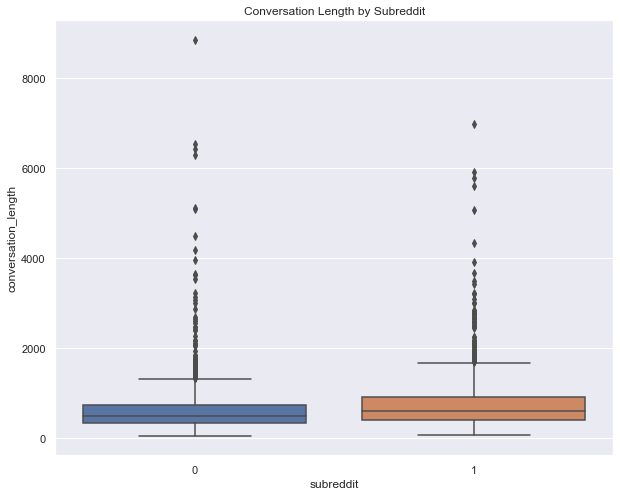

In [1052]:
plt.figure(figsize = (10, 8))
sns.boxplot(y = df1['conversation_length'], \
            x = df1['subreddit']).set_title('Conversation Length by Subreddit')

Text(0.5, 1.0, 'Adj Use by Subreddit Comments')

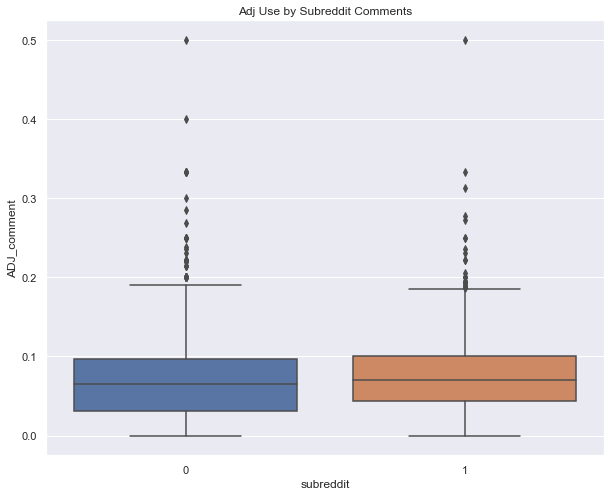

In [1053]:
plt.figure(figsize = (10, 8))
sns.boxplot(y = df1['ADJ_comment'], \
            x = df1['subreddit']).set_title('Adj Use by Subreddit Comments')

Text(0.5, 1.0, 'Adp Use by Subreddit Comments')

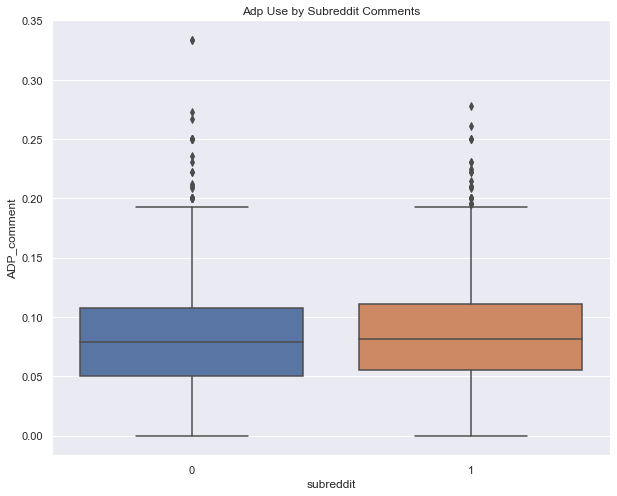

In [1054]:
plt.figure(figsize = (10, 8))
sns.boxplot(y = df1['ADP_comment'], \
            x = df1['subreddit']).set_title('Adp Use by Subreddit Comments')

Text(0.5, 1.0, 'Noun Use by Subreddit Comments')

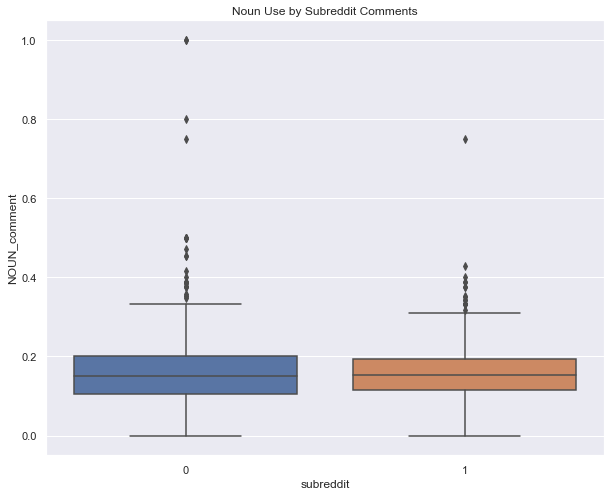

In [1055]:
plt.figure(figsize = (10, 8))
sns.boxplot(y = df1['NOUN_comment'],\
            x = df1['subreddit']).set_title('Noun Use by Subreddit Comments')

Text(0.5, 1.0, 'Comments by Subreddit')

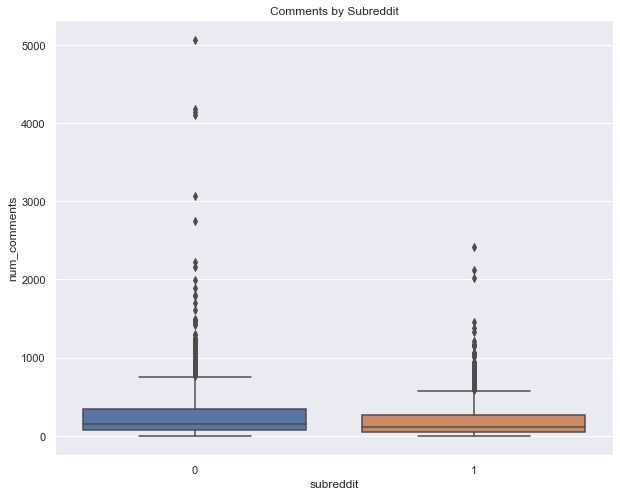

In [1056]:
plt.figure(figsize = (10, 8))
sns.boxplot(y = df1['num_comments'],\
            x = df1['subreddit']).set_title('Comments by Subreddit')

Text(0.5, 1.0, 'Upvotes by Subreddit')

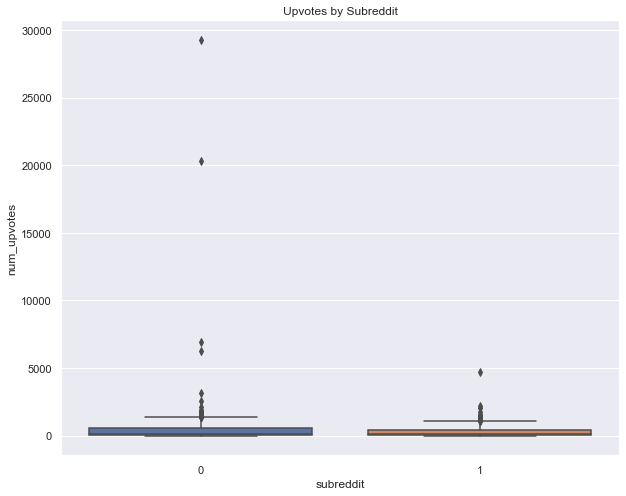

In [1057]:
plt.figure(figsize = (10, 8))
sns.boxplot(y = df1['num_upvotes'],\
            x = df1['subreddit']).set_title('Upvotes by Subreddit')

# Lemming the Text

In [1058]:
# lemmatize the words 

lemmatizer = WordNetLemmatizer()


#lemmatize words (exclude war and was as they were being lemmatized incorrectly)
df1['lemmed_conversation'] = [' '.join([word.text if (word.text == 'was') | \
                                        (word.text == 'war') else
    lemmatizer.lemmatize(word.text) for word in nlp(t)]) for t in df1.conversation]

# https://stackoverflow.com/questions/59567357/lemmatize-tokenised-column-in-pandas

In [1059]:
df1.to_csv('./progress_datasets/lemmed_df.csv', index = False)

In [1060]:
df2 = pd.read_csv('./progress_datasets/lemmed_df.csv')

In [1061]:
df2.head()

,id,title,num_comments,body,num_upvotes,time_posted,time_now,time_delta,subreddit,top_comment,...,PROPN_comment,DET_comment,PUNCT_comment,CCONJ_comment,PRON_comment,SYM_comment,INTJ_comment,NOUN_comment,ADP_comment,lemmed_conversation
0,nb0592,how common is it to not have your country's mo...,3,"/r/titlegoretaken spain as a whole, the most w...",3,2021-05-12 21:37:16,2021-05-13 01:20:57.717158,0 days 03:43:41.717163,1,About 40% of the population speaks French. Inc...,...,0.027778,0.055556,0.083333,0.027778,0.055556,0.0,0.000000,0.250000,0.083333,how common is it to not have your country 's m...
1,nb3wei,most popular fast food restaurant/take-away?,14,hey guys i’m not from usa but i have seen many...,3,2021-05-13 00:31:12,2021-05-13 01:20:57.864588,0 days 00:49:45.864594,0,"McDonalds, Subway and Starbucks are probably t...",...,0.061404,0.096491,0.078947,0.070175,0.078947,0.0,0.000000,0.078947,0.087719,most popular fast food restaurant / take - awa...
2,nb339e,is it true that you guys don't like/go to mcdo...,55,here in my country they're one of the most pop...,3,2021-05-12 23:52:33,2021-05-13 01:20:58.146242,0 days 01:28:25.146249,0,It’s not my first choice by far. I’d rather go...,...,0.190476,0.000000,0.095238,0.000000,0.142857,0.0,0.000000,0.047619,0.142857,is it true that you guy do not like / go to mc...
3,nb2x64,why were football fans so upset by the europea...,3,it seemed to me like it would increase the lev...,0,2021-05-12 23:44:35,2021-05-13 01:20:58.274452,0 days 01:36:23.274458,1,"Cause fans don\'t want ""top-notch matches"" in ...",...,0.052910,0.121693,0.142857,0.031746,0.047619,0.0,0.005291,0.137566,0.095238,why were football fan so upset by the european...
4,nb0xx6,why do people stick four fingers out?,29,usually it's people in a lifted truck who do i...,1,2021-05-12 22:13:39,2021-05-13 01:20:58.525647,0 days 03:07:19.525654,0,Are you talking about waving? Do we seriously...,...,0.000000,0.000000,0.125000,0.000000,0.125000,0.0,0.000000,0.000000,0.062500,why do people stick four finger out ? usually ...


In [1062]:
# tfidf fit to lemmed words 

tvec = TfidfVectorizer(
                        stop_words = my_stop_words,
                       strip_accents = 'ascii',
                       max_features = 100,
                       max_df = .60,
                       norm = 'l2'
)

# fit our vectorizer
tvec.fit(df2.lemmed_conversation)

# show tfidf df
lemmed_df_tvec = pd.DataFrame(tvec.transform(df2.lemmed_conversation).todense(),
                  columns = tvec.get_feature_names())


# lemmed_df_tvec['target'] = df.subreddit

# show df
# lemmed_df_tvec.sort_values('target', ascending = False)  #sorts values

lemmed_df_tvec

,actually,amendment,area,bad,best,better,big,called,car,child,...,url,use,used,usually,want,way,word,work,world,year
0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.00000,0.0,0.171024,...,0.000000,0.064256,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.054868
1,0.146656,0.0,0.157232,0.0,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,...,0.000000,0.000000,0.0,0.150988,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2,0.000000,0.0,0.000000,0.0,0.000000,0.30084,0.000000,0.00000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,0.000000,0.0,0.000000,0.0,0.612752,0.00000,0.184430,0.00000,0.0,0.000000,...,0.000000,0.000000,0.0,0.184430,0.493001,0.000000,0.0,0.000000,0.0,0.000000
4,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,...,0.000000,0.000000,0.0,0.653799,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2659,0.000000,0.0,0.000000,0.0,0.137551,0.00000,0.124203,0.00000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.110670,0.000000,0.0,0.357401,0.0,0.000000
2660,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.422457
2661,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,...,0.244586,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2662,0.000000,0.0,0.000000,0.0,0.395712,0.00000,0.000000,0.00000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


# Sentiment Analysis

In [1063]:
df2['comment_sentiment'] = [nlp(row) for row in df2.top_comment]
df2['comment_sentiment'].head()

0    (About, 40, %, of, the, population, speaks, Fr...
1    (McDonalds, ,, Subway, and, Starbucks, are, pr...
2    (It, ’s, not, my, first, choice, by, far, ., I...
3    (Cause, fans, don\'t, want, ", top, -, notch, ...
4    (Are, you, talking, about, waving, ?,  , Do, w...
Name: comment_sentiment, dtype: object

In [1064]:
df2['comment_polarity'] = [string._.polarity for string in df2.comment_sentiment]

Text(0.5, 1.0, 'Polarity by Subreddit Comment')

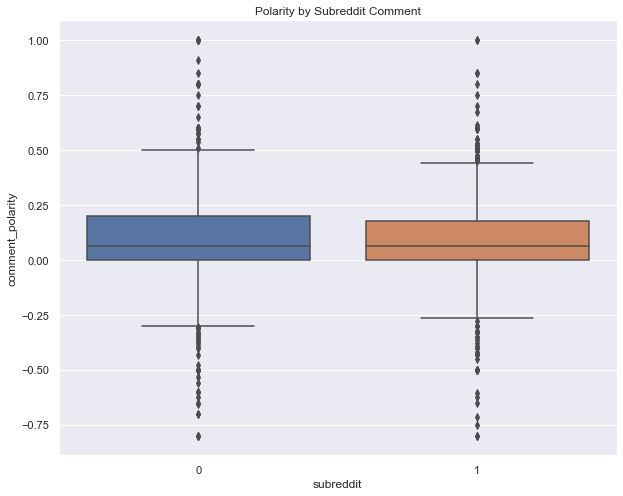

In [1065]:
plt.figure(figsize = (10, 8))
sns.boxplot(y = df2['comment_polarity'],\
            x = df2['subreddit']).set_title('Polarity by Subreddit Comment')

In [1066]:
df2['comment_subjectivity'] = [string._.subjectivity for 
                               string in df2.comment_sentiment]

Text(0.5, 1.0, 'Subjectivity by Subreddit Comment')

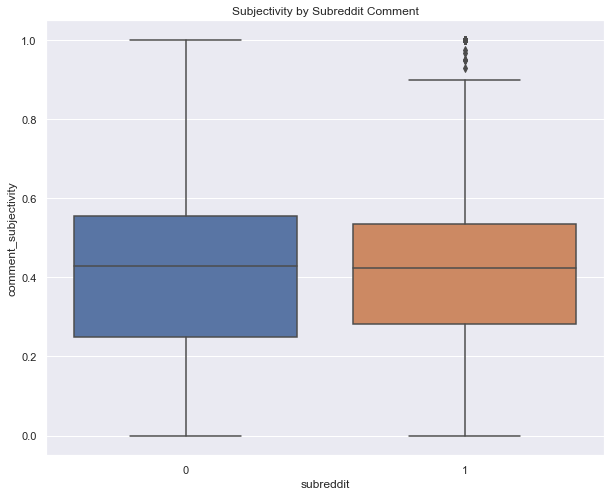

In [1067]:
plt.figure(figsize = (10, 8))
sns.boxplot(y = df2['comment_subjectivity'], \
            x = df2['subreddit']).set_title('Subjectivity by Subreddit Comment')

In [1068]:
df2.corr()['subreddit'].sort_values()

num_comments           -0.118546
AUX_comment            -0.086245
PRON_comment           -0.076416
num_upvotes            -0.061094
PART_comment           -0.052347
INTJ_comment           -0.048305
VERB_comment           -0.032200
comment_polarity       -0.022760
PROPN_comment          -0.021813
SCONJ_comment          -0.017501
X_comment               0.000867
NOUN_comment            0.004120
comment_subjectivity    0.004642
CCONJ_comment           0.014523
DET_comment             0.019473
ADV_comment             0.025920
SPACE_comment           0.033663
ADP_comment             0.040777
NUM_comment             0.043588
title_length            0.046626
ADJ_comment             0.051225
SYM_comment             0.052152
question_length         0.056799
text_length             0.063033
PUNCT_comment           0.087395
conversation_length     0.109117
comment_length          0.115056
subreddit               1.000000
Name: subreddit, dtype: float64

In [1069]:
df2['subreddit'].value_counts(normalize = True)

0    0.507132
1    0.492868
Name: subreddit, dtype: float64

In [1070]:
df2.to_csv('./progress_datasets/data_for_modeling.csv', index = False)

In [1071]:
model_df = pd.read_csv('./progress_datasets/data_for_modeling.csv')

In [1072]:
model_df.head()

,id,title,num_comments,body,num_upvotes,time_posted,time_now,time_delta,subreddit,top_comment,...,CCONJ_comment,PRON_comment,SYM_comment,INTJ_comment,NOUN_comment,ADP_comment,lemmed_conversation,comment_sentiment,comment_polarity,comment_subjectivity
0,nb0592,how common is it to not have your country's mo...,3,"/r/titlegoretaken spain as a whole, the most w...",3,2021-05-12 21:37:16,2021-05-13 01:20:57.717158,0 days 03:43:41.717163,1,About 40% of the population speaks French. Inc...,...,0.027778,0.055556,0.0,0.000000,0.250000,0.083333,how common is it to not have your country 's m...,About 40% of the population speaks French. Inc...,-0.041667,0.041667
1,nb3wei,most popular fast food restaurant/take-away?,14,hey guys i’m not from usa but i have seen many...,3,2021-05-13 00:31:12,2021-05-13 01:20:57.864588,0 days 00:49:45.864594,0,"McDonalds, Subway and Starbucks are probably t...",...,0.070175,0.078947,0.0,0.000000,0.078947,0.087719,most popular fast food restaurant / take - awa...,"McDonalds, Subway and Starbucks are probably t...",0.157143,0.398214
2,nb339e,is it true that you guys don't like/go to mcdo...,55,here in my country they're one of the most pop...,3,2021-05-12 23:52:33,2021-05-13 01:20:58.146242,0 days 01:28:25.146249,0,It’s not my first choice by far. I’d rather go...,...,0.000000,0.142857,0.0,0.000000,0.047619,0.142857,is it true that you guy do not like / go to mc...,It’s not my first choice by far. I’d rather go...,0.175000,0.666667
3,nb2x64,why were football fans so upset by the europea...,3,it seemed to me like it would increase the lev...,0,2021-05-12 23:44:35,2021-05-13 01:20:58.274452,0 days 01:36:23.274458,1,"Cause fans don\'t want ""top-notch matches"" in ...",...,0.031746,0.047619,0.0,0.005291,0.137566,0.095238,why were football fan so upset by the european...,"Cause fans don\'t want ""top-notch matches"" in ...",0.180590,0.456146
4,nb0xx6,why do people stick four fingers out?,29,usually it's people in a lifted truck who do i...,1,2021-05-12 22:13:39,2021-05-13 01:20:58.525647,0 days 03:07:19.525654,0,Are you talking about waving? Do we seriously...,...,0.000000,0.125000,0.0,0.000000,0.000000,0.062500,why do people stick four finger out ? usually ...,Are you talking about waving? Do we seriously...,-0.333333,0.666667


In [1073]:
model_df.columns

Index(['id', 'title', 'num_comments', 'body', 'num_upvotes', 'time_posted',
       'time_now', 'time_delta', 'subreddit', 'top_comment', 'text_length',
       'comment_length', 'title_length', 'question', 'question_length',
       'conversation', 'conversation_length', 'AUX_comment', 'NUM_comment',
       'ADV_comment', 'SCONJ_comment', 'VERB_comment', 'ADJ_comment',
       'SPACE_comment', 'PART_comment', 'X_comment', 'PROPN_comment',
       'DET_comment', 'PUNCT_comment', 'CCONJ_comment', 'PRON_comment',
       'SYM_comment', 'INTJ_comment', 'NOUN_comment', 'ADP_comment',
       'lemmed_conversation', 'comment_sentiment', 'comment_polarity',
       'comment_subjectivity'],
      dtype='object')

In [1074]:
model_df.dtypes

id                       object
title                    object
num_comments              int64
body                     object
num_upvotes               int64
time_posted              object
time_now                 object
time_delta               object
subreddit                 int64
top_comment              object
text_length               int64
comment_length            int64
title_length              int64
question                 object
question_length           int64
conversation             object
conversation_length       int64
AUX_comment             float64
NUM_comment             float64
ADV_comment             float64
SCONJ_comment           float64
VERB_comment            float64
ADJ_comment             float64
SPACE_comment           float64
PART_comment            float64
X_comment               float64
PROPN_comment           float64
DET_comment             float64
PUNCT_comment           float64
CCONJ_comment           float64
PRON_comment            float64
SYM_comm

# Punctuation Types

In [1075]:
#count occurances of specific types of punctuation
punct_for_df = model_df.top_comment.map(lambda x: \
                                        Counter([word.text for
                                                 word in nlp(x) if 
                                                 word.pos_ == 'PUNCT']))

In [1076]:
punct_for_df

0                                        {'.': 2, ',': 1}
1                        {',': 1, '.': 6, '(': 1, ')': 1}
2                                                {'.': 2}
3              {'"': 6, '-': 2, ',': 9, '.': 8, '...': 2}
4                                                {'?': 2}
                              ...                        
2659    {',': 17, '(': 5, ')': 4, '.': 14, '-': 6, '*'...
2660                                    {'..': 1, '.': 1}
2661                             {'.': 1, '-': 2, ')': 1}
2662                                     {',': 2, '.': 1}
2663                     {'.': 3, '*': 2, ',': 2, '!': 1}
Name: top_comment, Length: 2664, dtype: object

In [1077]:
#make a set of punctiation
all_punc = list(set([key for punc_counter in 
                     punct_for_df for key in punc_counter.keys()]))

In [1078]:
# make a set of punctuation types I want to focus on
punc_to_count = [':P', '👍', '…', ',', ':',':(', ':))', ';', '.', '!', '?', ':)']

In [1079]:
all_punc

["They\\'re",
 '“',
 "I\\'m",
 '\\n\\nBut',
 '...',
 'away"/"tossed"/"laid',
 'db5f',
 'y1mkSm00kXM',
 '👍',
 '’s',
 '>',
 '^(I',
 '«',
 '\\n\\nRegardless',
 'state/',
 ';',
 '\\n\\nSnake',
 'x',
 '~0.67',
 '-----',
 '(',
 "'",
 '\\n\\nWinter',
 '):',
 'Italo_dance',
 '.',
 'outside/',
 '=',
 'kazn/',
 '~2000',
 'Italo_disco',
 ':',
 '\\n\\nGotta',
 '\\n\\nHowever',
 '\\n\\nToday',
 '-opoulos',
 '-uh',
 '\\n\\nState',
 '\\n\\nAbout',
 ',',
 '"',
 'e6eXyYJ4h5o',
 '{',
 '/u',
 '\\n\\nNowadays',
 '’d',
 ':P',
 '\\n\\nClose',
 ']',
 '-a',
 '[',
 '.....',
 '/',
 '”\\n\\nI',
 '?',
 '*',
 'beschikbaar/0',
 'inch/',
 'https://spicysouthernkitchen.com/sweet-potato-casserole-with-marshmallows/',
 '/i/',
 'EaAnn2EALw_wcB',
 '-',
 '....',
 '\\n\\nWorks',
 'img/2015/12/15',
 'acknowledgements/',
 '}',
 ':)',
 '–',
 '\\n\\nBlister',
 'home/',
 ':))',
 '-10C',
 'Italo_house',
 'Twilight_anesthesia',
 '~',
 '\\n\\nSpringfield',
 '6**\\n\\n\\\\-',
 '’',
 'varld/',
 'lxSy4xjiMwk?t=33',
 '\\n\\nFirst',
 '

In [1080]:
# add punc to df in columns

for punc in punc_to_count:
    model_df[punc] = 0

In [1081]:
# add freq of punctuation types to dataframe as columns

for index, row in enumerate(punct_for_df):
    total = sum([item[1] for item in row.items()])
    for item in row.items():
        if item[0] in model_df.columns:
            model_df.loc[index, item[0]] = item[1]/total

In [1082]:
model_df.head()

,id,title,num_comments,body,num_upvotes,time_posted,time_now,time_delta,subreddit,top_comment,...,…,",",:,:(,:)),;,.,!,?,:)
0,nb0592,how common is it to not have your country's mo...,3,"/r/titlegoretaken spain as a whole, the most w...",3,2021-05-12 21:37:16,2021-05-13 01:20:57.717158,0 days 03:43:41.717163,1,About 40% of the population speaks French. Inc...,...,0.0,0.333333,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0
1,nb3wei,most popular fast food restaurant/take-away?,14,hey guys i’m not from usa but i have seen many...,3,2021-05-13 00:31:12,2021-05-13 01:20:57.864588,0 days 00:49:45.864594,0,"McDonalds, Subway and Starbucks are probably t...",...,0.0,0.111111,0.0,0.0,0.0,0.0,0.666667,0.0,0.0,0.0
2,nb339e,is it true that you guys don't like/go to mcdo...,55,here in my country they're one of the most pop...,3,2021-05-12 23:52:33,2021-05-13 01:20:58.146242,0 days 01:28:25.146249,0,It’s not my first choice by far. I’d rather go...,...,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
3,nb2x64,why were football fans so upset by the europea...,3,it seemed to me like it would increase the lev...,0,2021-05-12 23:44:35,2021-05-13 01:20:58.274452,0 days 01:36:23.274458,1,"Cause fans don\'t want ""top-notch matches"" in ...",...,0.0,0.333333,0.0,0.0,0.0,0.0,0.296296,0.0,0.0,0.0
4,nb0xx6,why do people stick four fingers out?,29,usually it's people in a lifted truck who do i...,1,2021-05-12 22:13:39,2021-05-13 01:20:58.525647,0 days 03:07:19.525654,0,Are you talking about waving? Do we seriously...,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0


In [1083]:
model_df.isna().sum().sum()

0

In [1084]:
emojis = [':P', '👍', ':(', ':))', ':)']

In [1085]:
#combining emoji columns
model_df['emojis'] = model_df[':P'] + model_df['👍']+ model_df[':(']+ model_df[':))']+model_df[':)']

#dropping original emoji columns 
model_df.drop(columns = [':P', '👍', ':(', ':))', ':)'], inplace = True)

Text(0.5, 1.0, 'Emoji by Subreddit Comment')

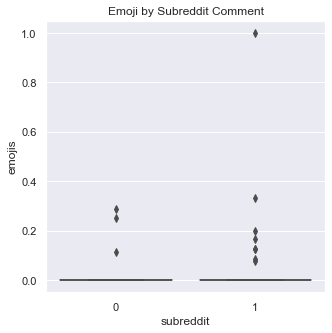

In [1086]:
plt.figure(figsize = (5,5))
sns.boxplot(y = model_df['emojis'],\
            x = model_df['subreddit']).set_title('Emoji by Subreddit Comment')

Text(0.5, 1.0, 'Ellipsis by Subreddit Comment')

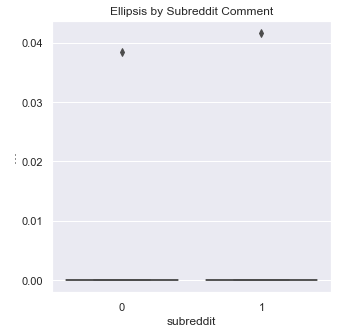

In [1087]:
plt.figure(figsize = (5,5))
sns.boxplot(y = model_df['…'], \
            x = model_df['subreddit']).set_title('Ellipsis by Subreddit Comment')

Text(0.5, 1.0, 'Comma by Subreddit Comment')

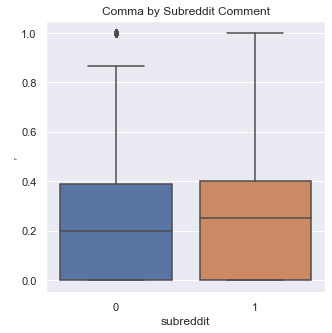

In [1088]:
plt.figure(figsize = (5, 5))
sns.boxplot(y = model_df[','], \
            x = model_df['subreddit']).set_title('Comma by Subreddit Comment')

Text(0.5, 1.0, 'Colon by Subreddit Comment')

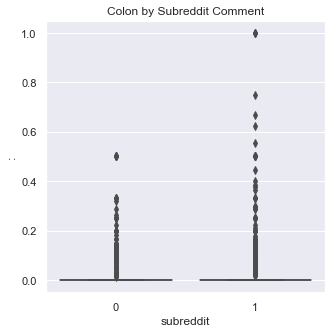

In [1089]:
plt.figure(figsize = (5, 5))
sns.boxplot(y = model_df[':'], \
            x = model_df['subreddit']).set_title('Colon by Subreddit Comment')

Text(0.5, 1.0, 'Excalamation Point by Subreddit Comment')

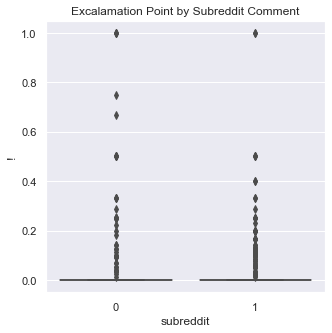

In [1090]:
plt.figure(figsize = (5, 5))
sns.boxplot(y = model_df['!'], x = model_df[
    'subreddit']).set_title('Excalamation Point by Subreddit Comment')

Text(0.5, 1.0, 'Question Mark by Subreddit Comment')

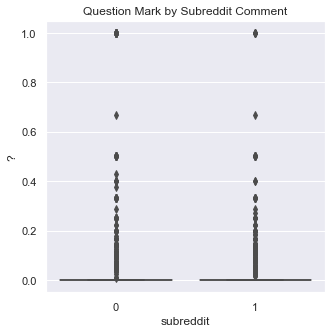

In [1091]:
plt.figure(figsize = (5, 5))
sns.boxplot(y = model_df['?'], x = model_df[
    'subreddit']).set_title('Question Mark by Subreddit Comment')

Text(0.5, 1.0, 'Semi-colon by Subreddit Comment')

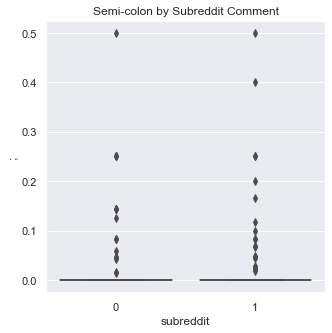

In [1092]:
plt.figure(figsize = (5, 5))
sns.boxplot(y = model_df[';'], x = model_df[
    'subreddit']).set_title('Semi-colon by Subreddit Comment')

Text(0.5, 1.0, 'Period by Subreddit Comment')

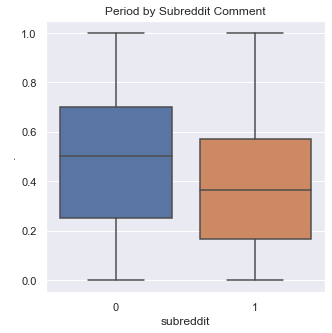

In [1093]:
plt.figure(figsize = (5, 5))
sns.boxplot(y = model_df['.'], x = model_df[
    'subreddit']).set_title('Period by Subreddit Comment')

**Interpretation**
Americans employ periods slightly more than per punctuation type than Europeans when responding. 
This must be explored further but may be due to Americans using less complex setences without the need for conjunctions and commas? Or is it that Americans write shorter comments overall, contributing to a higher frequency?

In [1094]:
model_df.to_csv('./progress_datasets/final_df.csv', index = False)

In [1095]:
final = pd.read_csv('./progress_datasets/final_df.csv')

In [1096]:
final.corr()['subreddit'].sort_values()

.                      -0.133793
num_comments           -0.118546
AUX_comment            -0.086245
PRON_comment           -0.076416
num_upvotes            -0.061094
?                      -0.053929
PART_comment           -0.052347
INTJ_comment           -0.048305
VERB_comment           -0.032200
comment_polarity       -0.022760
PROPN_comment          -0.021813
SCONJ_comment          -0.017501
!                      -0.001599
X_comment               0.000867
…                       0.001486
NOUN_comment            0.004120
comment_subjectivity    0.004642
;                       0.007761
CCONJ_comment           0.014523
DET_comment             0.019473
emojis                  0.024818
ADV_comment             0.025920
SPACE_comment           0.033663
ADP_comment             0.040777
NUM_comment             0.043588
title_length            0.046626
ADJ_comment             0.051225
SYM_comment             0.052152
question_length         0.056799
text_length             0.063033
,         

# Topic Modeling with LatentDirichletAllocation

[source](https://medium.com/@yanlinc/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6)

In [1097]:
# Get topics

lda_model = LatentDirichletAllocation(n_components= 5, 
                                      n_jobs = -1, 
                                      learning_method = 'online')

lda_results = lda_model.fit_transform(lemmed_df_tvec)

In [1098]:
# Make df of topics
topicnames = ['Topic' + str(i) for i in range(lda_model.n_components)]

topic_df = pd.DataFrame(lda_results, columns=topicnames)

In [1099]:
topic_df['subreddit'] = final['subreddit']

Text(0.5, 1.0, 'Topic0 by Subreddit')

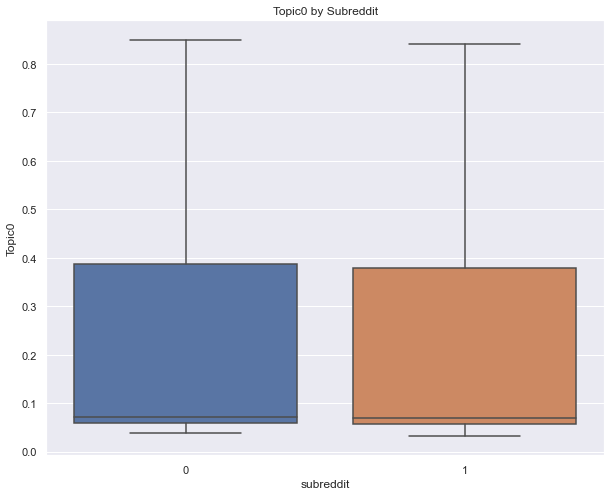

In [1100]:
plt.figure(figsize = (10, 8))
sns.boxplot(y = topic_df['Topic0'], x = topic_df['subreddit'])\
.set_title('Topic0 by Subreddit')

Text(0.5, 1.0, 'Topic1 by Subreddit')

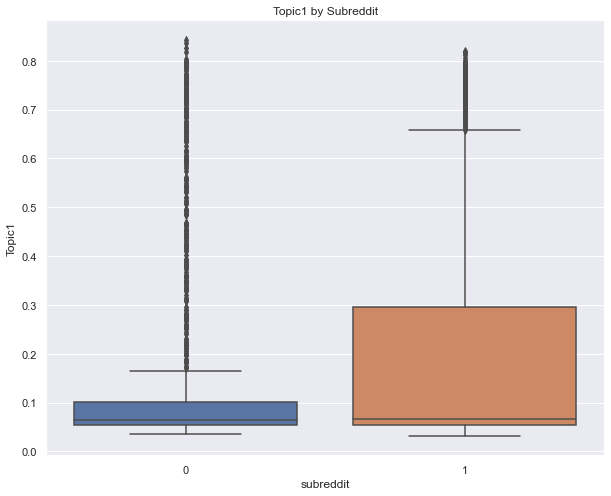

In [1101]:
plt.figure(figsize = (10, 8))
sns.boxplot(y = topic_df['Topic1'], x = topic_df['subreddit'])\
.set_title('Topic1 by Subreddit')

Text(0.5, 1.0, 'Topic2 by Subreddit')

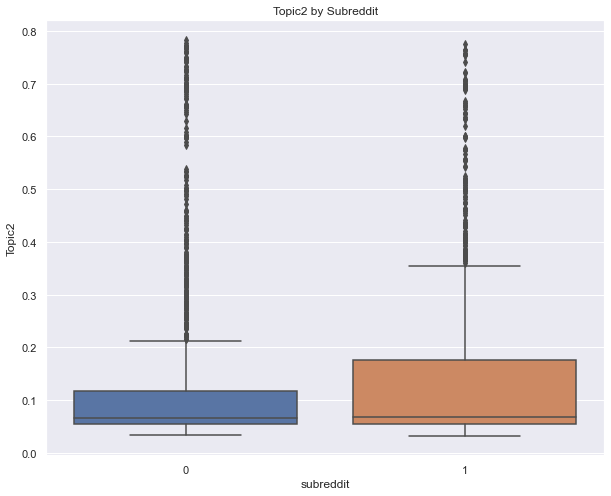

In [1102]:
plt.figure(figsize = (10, 8))
sns.boxplot(y = topic_df['Topic2'], x = topic_df['subreddit'])\
.set_title('Topic2 by Subreddit')

Text(0.5, 1.0, 'Topic3 by Subreddit')

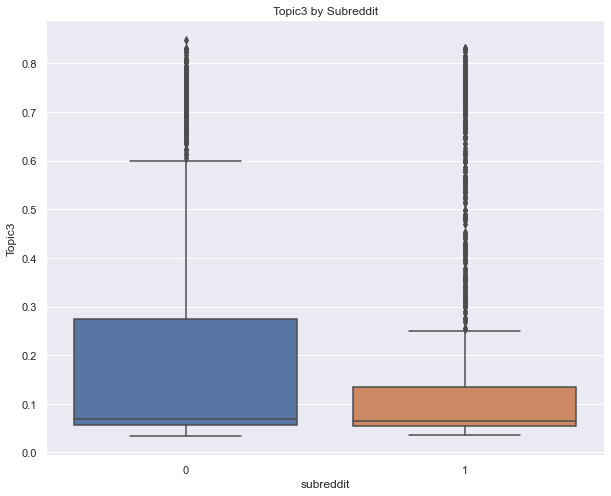

In [1103]:
plt.figure(figsize = (10, 8))
sns.boxplot(y = topic_df['Topic3'], x = topic_df['subreddit'])\
.set_title('Topic3 by Subreddit')

Text(0.5, 1.0, 'Topic4 by Subreddit')

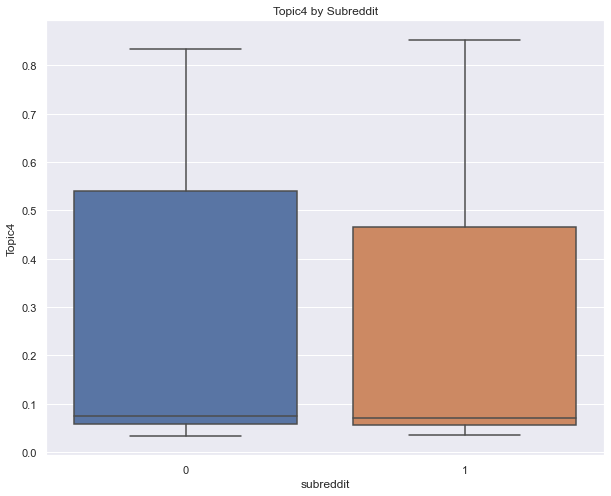

In [1104]:
plt.figure(figsize = (10, 8))
sns.boxplot(y = topic_df['Topic4'], x = topic_df['subreddit'])\
.set_title('Topic4 by Subreddit')

In [1105]:
topic_df.sort_values('Topic0')

,Topic0,Topic1,Topic2,Topic3,Topic4,subreddit
1367,0.033291,0.032596,0.043400,0.636186,0.254526,1
2187,0.035471,0.034662,0.187585,0.248610,0.493671,1
2089,0.036257,0.119147,0.079973,0.728915,0.035707,1
350,0.036608,0.035253,0.035326,0.321066,0.571747,1
220,0.037406,0.036958,0.036735,0.036751,0.852150,1
...,...,...,...,...,...,...
1401,0.832454,0.041463,0.041387,0.042446,0.042249,1
1164,0.836275,0.040574,0.040382,0.040960,0.041809,1
2304,0.840517,0.039832,0.039311,0.040144,0.040196,1
1968,0.845546,0.037894,0.038274,0.039562,0.038724,0


In [1106]:
# # Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = tvec.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head()

,actually,amendment,area,bad,best,better,big,called,car,child,...,url,use,used,usually,want,way,word,work,world,year
Topic0,17.836179,0.200253,39.483464,4.118568,6.629142,0.225988,14.732503,0.202664,41.524272,0.202079,...,10.020401,12.726626,11.666957,20.028090,46.219536,18.062954,0.202757,9.736420,0.223108,34.292232
Topic1,6.684710,15.976779,2.500151,7.692132,0.353047,0.206260,0.720079,0.210241,0.201590,0.203640,...,6.920967,61.217842,29.743749,2.822847,7.163365,18.743317,78.403860,4.708639,4.720130,5.684655
Topic2,0.205892,0.200464,5.550438,0.204293,32.878330,0.205173,3.026140,52.454441,0.201574,0.201446,...,51.177257,0.202669,5.570238,3.178555,0.204917,0.210324,0.203052,0.204097,31.338958,1.453312
Topic3,10.241078,0.200146,0.208663,5.292642,10.627222,12.797947,2.069094,0.272565,0.202313,32.932587,...,16.451589,12.362512,10.472397,2.582040,16.567607,15.875292,0.207042,38.049863,1.006149,28.808147
Topic4,23.647951,0.322583,8.203535,29.737748,0.204926,29.095455,38.551683,0.203327,0.202144,0.202000,...,14.853312,11.207040,15.550986,27.488781,14.680519,22.348033,0.201861,17.754568,19.131019,48.627968


In [1107]:
# get top words per topic 

def show_topics(vectorizer=TfidfVectorizer, 
                lda_model=lda_model, n_words=5,
                learning_method = 'online'):
    keywords = np.array(tvec.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords


topic_keywords = show_topics(vectorizer=TfidfVectorizer, lda_model=lda_model, n_words=5)

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4
Topic 0,people,know,like,home,live
Topic 1,language,word,state,use,say
Topic 2,city,called,url,party,town
Topic 3,school,feel,kid,did,work
Topic 4,like,people,just,thing,good


**Interpretation** 

From the boxplots above, we see that the majority of topics are equal among questions asked of Europeans and Americans. 

Topics 2 and 3 are more popular to be asked of Americans while Topic 4 is the most common topic for AskEurope. 

Looking at the words in the topic dataframe, it seems as though Topic 0 corresponds to popular things around cities, Topic 1 to work hours potentially,  Topic 2 to food, Topic 3 to politics, and 4 to language and education. 

The topics definitely need to be explored more in terms of checking their accuracy and what may have been left out. 

# Prepping for Modeling 

In [1108]:
final.shape, topic_df.shape

((2664, 47), (2664, 6))

In [1109]:
final.isna().sum().sum()

0

In [1110]:
final.columns

Index(['id', 'title', 'num_comments', 'body', 'num_upvotes', 'time_posted',
       'time_now', 'time_delta', 'subreddit', 'top_comment', 'text_length',
       'comment_length', 'title_length', 'question', 'question_length',
       'conversation', 'conversation_length', 'AUX_comment', 'NUM_comment',
       'ADV_comment', 'SCONJ_comment', 'VERB_comment', 'ADJ_comment',
       'SPACE_comment', 'PART_comment', 'X_comment', 'PROPN_comment',
       'DET_comment', 'PUNCT_comment', 'CCONJ_comment', 'PRON_comment',
       'SYM_comment', 'INTJ_comment', 'NOUN_comment', 'ADP_comment',
       'lemmed_conversation', 'comment_sentiment', 'comment_polarity',
       'comment_subjectivity', '…', ',', ':', ';', '.', '!', '?', 'emojis'],
      dtype='object')

# Pipeline for Modeling

In [1111]:
tvec = CountVectorizer(
                        stop_words = my_stop_words,
                       strip_accents = 'ascii',
                       max_features = 50,
                       max_df = .70
)

# fit our vectorizer
tvec.fit(final.lemmed_conversation)

# show tfidf matrix
df_tvec = pd.DataFrame(tvec.transform(final.lemmed_conversation).todense(),
                  columns = tvec.get_feature_names())

In [1112]:
#comparing words from CountVectorizer
df_tvec.columns

Index(['actually', 'amendment', 'big', 'city', 'come', 'common', 'did',
       'different', 'edit', 'example', 'family', 'feel', 'food', 'friend',
       'going', 'good', 'house', 'just', 'kind', 'know', 'language', 'life',
       'like', 'live', 'lot', 'make', 'mean', 'new', 'people', 'place',
       'popular', 'pretty', 'question', 'really', 'right', 'say', 'school',
       'state', 'thing', 'think', 'time', 'url', 'use', 'used', 'usually',
       'want', 'way', 'word', 'work', 'year'],
      dtype='object')

In [1113]:
#Comparing words from tfidfvectorizer 
lemmed_df_tvec.columns

Index(['actually', 'amendment', 'area', 'bad', 'best', 'better', 'big',
       'called', 'car', 'child', 'city', 'come', 'common', 'culture', 'did',
       'different', 'edit', 'especially', 'example', 'experience', 'family',
       'far', 'feel', 'food', 'friend', 'going', 'good', 'got', 'government',
       'great', 'guy', 'having', 'heard', 'high', 'history', 'home', 'house',
       'job', 'just', 'kid', 'kind', 'know', 'language', 'law', 'le', 'life',
       'like', 'live', 'living', 'local', 'long', 'look', 'lot', 'love',
       'make', 'maybe', 'mean', 'need', 'new', 'non', 'old', 'parent', 'party',
       'people', 'person', 'place', 'popular', 'president', 'pretty',
       'probably', 'public', 'question', 'quite', 'really', 'right', 'said',
       'say', 'school', 'seen', 'similar', 'small', 'sound', 'state', 'term',
       'thing', 'think', 'thought', 'time', 'town', 'understand', 'url', 'use',
       'used', 'usually', 'want', 'way', 'word', 'work', 'world', 'year'],
      d

**Choosing a Vectorizer**

I am choosing to model with TfidfVectorizer because it keeps more words that are related to the hypothesis of topics I am intereseting in looking at; which words are used more often per subreddit to show what topics people are curious about.

In [1114]:
lemmed_df_tvec.columns

Index(['actually', 'amendment', 'area', 'bad', 'best', 'better', 'big',
       'called', 'car', 'child', 'city', 'come', 'common', 'culture', 'did',
       'different', 'edit', 'especially', 'example', 'experience', 'family',
       'far', 'feel', 'food', 'friend', 'going', 'good', 'got', 'government',
       'great', 'guy', 'having', 'heard', 'high', 'history', 'home', 'house',
       'job', 'just', 'kid', 'kind', 'know', 'language', 'law', 'le', 'life',
       'like', 'live', 'living', 'local', 'long', 'look', 'lot', 'love',
       'make', 'maybe', 'mean', 'need', 'new', 'non', 'old', 'parent', 'party',
       'people', 'person', 'place', 'popular', 'president', 'pretty',
       'probably', 'public', 'question', 'quite', 'really', 'right', 'said',
       'say', 'school', 'seen', 'similar', 'small', 'sound', 'state', 'term',
       'thing', 'think', 'thought', 'time', 'town', 'understand', 'url', 'use',
       'used', 'usually', 'want', 'way', 'word', 'work', 'world', 'year'],
      d

In [1115]:
topic_df.drop(columns = ['subreddit'], inplace = True)

In [1116]:
concat = pd.concat([final, lemmed_df_tvec], axis = 1)
concat = pd.concat([concat, topic_df], axis = 1)

In [1117]:
concat.columns[:20]

Index(['id', 'title', 'num_comments', 'body', 'num_upvotes', 'time_posted',
       'time_now', 'time_delta', 'subreddit', 'top_comment', 'text_length',
       'comment_length', 'title_length', 'question', 'question_length',
       'conversation', 'conversation_length', 'AUX_comment', 'NUM_comment',
       'ADV_comment'],
      dtype='object')

In [1118]:
concat.drop(columns = ['title_length', 'conversation_length',
                       'body', 'time_posted', 'time_now', 'time_delta',
                       'text_length', 'question', 'conversation', 'url',
                      'id', 'title', 'top_comment', 'lemmed_conversation', 'comment_sentiment'], inplace = True)

In [1119]:
concat.columns

Index(['num_comments', 'num_upvotes', 'subreddit', 'comment_length',
       'question_length', 'AUX_comment', 'NUM_comment', 'ADV_comment',
       'SCONJ_comment', 'VERB_comment',
       ...
       'way', 'word', 'work', 'world', 'year', 'Topic0', 'Topic1', 'Topic2',
       'Topic3', 'Topic4'],
      dtype='object', length=136)

In [1120]:
for column in concat.columns:
    print(column)

num_comments
num_upvotes
subreddit
comment_length
question_length
AUX_comment
NUM_comment
ADV_comment
SCONJ_comment
VERB_comment
ADJ_comment
SPACE_comment
PART_comment
X_comment
PROPN_comment
DET_comment
PUNCT_comment
CCONJ_comment
PRON_comment
SYM_comment
INTJ_comment
NOUN_comment
ADP_comment
comment_polarity
comment_subjectivity
…
,
:
;
.
!
?
emojis
actually
amendment
area
bad
best
better
big
called
car
child
city
come
common
culture
did
different
edit
especially
example
experience
family
far
feel
food
friend
going
good
got
government
great
guy
having
heard
high
history
home
house
job
just
kid
kind
know
language
law
le
life
like
live
living
local
long
look
lot
love
make
maybe
mean
need
new
non
old
parent
party
people
person
place
popular
president
pretty
probably
public
quite
really
right
said
say
school
seen
similar
small
sound
state
term
thing
think
thought
time
town
understand
use
used
usually
want
way
word
work
world
year
Topic0
Topic1
Topic2
Topic3
Topic4


In [1121]:
#saving to a csv for modeling
concat.to_csv('./prepared_data.csv', index = False)

In [1122]:
eda = pd.concat([final, lemmed_df_tvec], axis = 1)
eda = pd.concat([eda, topic_df], axis = 1)

In [1142]:
eda.to_csv('./progress_datasets/alltogether.csv', index=False)

In [1124]:
eda[['language', 'old', 'quite', 'edit', 'term', 'term', 'guy', 'state', 'amendment']].mean()

language     0.041218
old          0.016174
quite        0.015824
edit         0.027800
term         0.012543
term         0.012543
guy          0.022359
state        0.049112
amendment    0.006633
dtype: float64

In [1125]:
top_15 = lemmed_df_tvec.mean().sort_values(ascending = False)[:15]
top_15

like        0.085067
people      0.081865
just        0.065159
know        0.055962
think       0.053969
thing       0.050312
state       0.049112
time        0.043722
year        0.043543
really      0.043036
say         0.042965
language    0.041218
url         0.037188
lot         0.036961
use         0.035328
dtype: float64

In [1126]:
lemmed_df_tvec.columns

Index(['actually', 'amendment', 'area', 'bad', 'best', 'better', 'big',
       'called', 'car', 'child', 'city', 'come', 'common', 'culture', 'did',
       'different', 'edit', 'especially', 'example', 'experience', 'family',
       'far', 'feel', 'food', 'friend', 'going', 'good', 'got', 'government',
       'great', 'guy', 'having', 'heard', 'high', 'history', 'home', 'house',
       'job', 'just', 'kid', 'kind', 'know', 'language', 'law', 'le', 'life',
       'like', 'live', 'living', 'local', 'long', 'look', 'lot', 'love',
       'make', 'maybe', 'mean', 'need', 'new', 'non', 'old', 'parent', 'party',
       'people', 'person', 'place', 'popular', 'president', 'pretty',
       'probably', 'public', 'question', 'quite', 'really', 'right', 'said',
       'say', 'school', 'seen', 'similar', 'small', 'sound', 'state', 'term',
       'thing', 'think', 'thought', 'time', 'town', 'understand', 'url', 'use',
       'used', 'usually', 'want', 'way', 'word', 'work', 'world', 'year'],
      d

In [1127]:
lemmed_df_tvec['subreddit'] = final['subreddit']

In [1128]:
american_top_words = lemmed_df_tvec[lemmed_df_tvec['subreddit']==0].mean().sort_values(ascending=False).head(80)

In [1129]:
europe_top_words = lemmed_df_tvec[lemmed_df_tvec['subreddit']==1].mean().sort_values(ascending=False).head(80)

In [1130]:
american_top_words.index

Index(['like', 'state', 'people', 'just', 'think', 'thing', 'know', 'really',
       'time', 'did', 'year', 'say', 'lot', 'question', 'edit', 'want',
       'school', 'make', 'guy', 'feel', 'live', 'going', 'new', 'url', 'good',
       'place', 'work', 'use', 'common', 'life', 'different', 'city', 'seen',
       'thought', 'heard', 'friend', 'got', 'culture', 'area', 'way', 'mean',
       'come', 'love', 'food', 'popular', 'pretty', 'actually', 'house',
       'kind', 'home', 'best', 'need', 'family', 'used', 'right', 'example',
       'world', 'said', 'better', 'high', 'big', 'job', 'person', 'look',
       'town', 'kid', 'probably', 'great', 'understand', 'bad', 'car',
       'living', 'public', 'non', 'word', 'government', 'having', 'term',
       'usually', 'experience'],
      dtype='object')

In [1131]:
american_top_words = pd.DataFrame({'word':american_top_words.index, 'freq':american_top_words})
europe_top_words = pd.DataFrame({'word':europe_top_words.index,  'freq':europe_top_words})

In [1132]:
topic_df['subreddit'] = final['subreddit']

In [1133]:
topic_df.groupby('subreddit').mean()

,Topic0,Topic1,Topic2,Topic3,Topic4
subreddit,,,,,
0,0.222580,0.164588,0.140417,0.207470,0.264946
1,0.225413,0.212034,0.144528,0.172927,0.245098


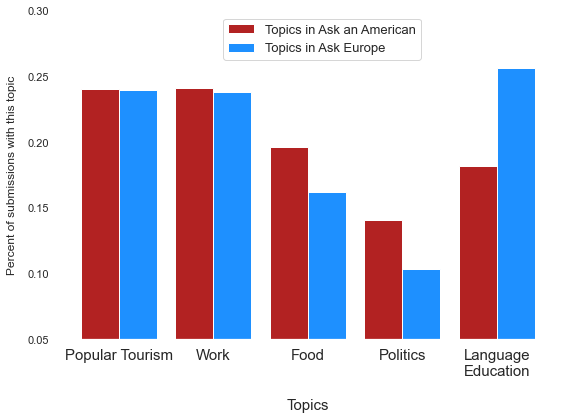

In [1134]:
# plotting bar plot of scores when tests are and are not required

labels = ['Popular Tourism', 'Work', 'Food', 'Politics', 'Language\nEducation']

lst_one = [0.240245, 0.24128, 0.196315, 0.140445,0.181713]
lst_two =  [0.240012, 0.237758, 0.162081, 0.103741, 0.256408]

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize = (8, 6))
rects1 = ax.bar(x - width/2, lst_one, width, label='Topics in Ask an American', color = 'firebrick')
rects2 = ax.bar(x + width/2, lst_two, width, label='Topics in Ask Europe', color = 'dodgerblue')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent of submissions with this topic', fontsize = 12, labelpad = 10)
ax.set_xlabel('Topics', fontsize = 15, labelpad = 20)


# setting up the graph
ax.set_ylim([.05,.3])
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize = 15)
ax.legend(loc = (0.33, .85), fontsize = 13, facecolor = 'white')
ax.set_facecolor('white')

fig.tight_layout()

plt.show();


**Interpretation**

While tourism and work life are both equally discussed in European and American subreddits, the other topics are where we can see cultural differences. Above all, Europeans are asked about language and education, while Americans are asked about indentically work and tourism, only then followed by language and education. 

Furthermore, more people want to know about food and politics in America as compared to in Europe. 

It would be interesting to examine what times poltics are discussed in regards to political events in America. 

In [1135]:
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4
Topic 0,people,know,like,home,live
Topic 1,language,word,state,use,say
Topic 2,city,called,url,party,town
Topic 3,school,feel,kid,did,work
Topic 4,like,people,just,thing,good


In [1136]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [1137]:
american_top_words

,word,freq
like,like,0.083872
state,state,0.082198
people,people,0.079399
just,just,0.070125
think,think,0.061082
...,...,...
government,government,0.015222
having,having,0.014941
term,term,0.014867
usually,usually,0.014800


In [1138]:
europe_top_words.drop('subreddit', inplace = True)

In [1139]:
d = dict(zip(american_top_words.word, american_top_words.freq))
# https://stackoverflow.com/questions/18012505/python-pandas-dataframe-columns-convert-to-dict-key-and-value

<Figure size 1440x720 with 0 Axes>

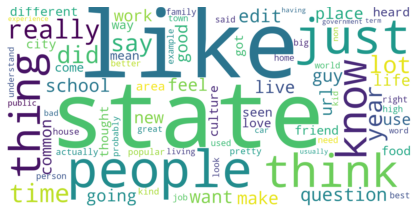

In [1140]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white')
plt.figure( figsize=(20,10), facecolor='k')
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear") 
plt.tight_layout(pad=0)
plt.axis("off")
plt.show();

<Figure size 2880x1440 with 0 Axes>

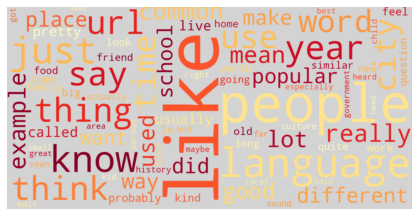

In [1141]:
d = dict(zip(europe_top_words.word, europe_top_words.freq))


wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='lightgrey', colormap = 'YlOrRd'
                     )
plt.figure( figsize=(40,20), facecolor='k')
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear") 
plt.tight_layout(pad=0)
plt.axis("off")
plt.show();

**Interpretation**

We can see that the most used words in both subreddits are 'people,' 'like,' as well as 'just,' and 'know.' 
It would be interesting to see the context around each word and why they show up so much. Because the subjectivity of both subreddits ranked fairly evenly, at just under 50\%, it is interesting to see words that are so common to opinions. 

It is also telling that the top words are similar, meaning that the language use and topics among subreddit posters and commenters do not differ greatly. 